In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

%matplotlib inline

In [8]:
data = pd.read_csv('all_outputs.csv')

## Looking at the raw data:

In [9]:
data.head()

,jj_m,reco_q_1,reco_q_2,reco_g_1,reco_g_2,jet_mom_1,jet_mom_2,jet_e_1,jet_e_2,jet_eta_1,jet_eta_2,jet_nchad_1,jet_nchad_2,jet_nconst_1,jet_nconst_2,label
0,122.086,0.122196,0.101619,0.699699,0.827713,48.4071,49.7014,68.7686,53.3260,1.127010,-1.113640,23,21,44,45,1
1,125.364,0.052471,0.485203,0.822686,0.394518,56.4287,55.8572,67.3314,58.0372,-0.966960,0.992363,20,12,50,24,1
2,123.899,0.116872,0.888024,0.292426,0.009174,59.8905,59.8366,63.0592,60.8402,0.683653,-0.681494,9,8,26,11,1
3,124.111,0.174939,0.041289,0.775762,0.834111,48.0868,48.4018,73.2336,50.8795,-0.100210,0.099877,20,14,55,33,1
4,125.215,0.002004,0.144856,0.073018,0.423673,59.0139,58.1796,65.8322,59.3867,1.172700,-1.163360,24,12,54,29,1


In [10]:
print('Size of data: {}'.format(data.shape))
print('Number of events: {}'.format(data.shape[0]))
print('Number of columns: {}'.format(data.shape[1]))

print ('\nList of features in dataset:')
for col in data.columns:
    print(col)

Size of data: (300000, 16)
Number of events: 300000
Number of columns: 16

List of features in dataset:
jj_m
reco_q_1
reco_q_2
reco_g_1
reco_g_2
jet_mom_1
jet_mom_2
jet_e_1
jet_e_2
jet_eta_1
jet_eta_2
jet_nchad_1
jet_nchad_2
jet_nconst_1
jet_nconst_2
label


In [15]:
print('Number of signal events: {}'.format(len(data[data.label == 1])))
print('Number of background events: {}'.format(len(data[data.label == 0])))
print('Fraction signal: {}'.format(len(data[data.label == 1])/(float)(len(data[data.label == 1]) + len(data[data.label == 0]))))

Number of signal events: 200000
Number of background events: 100000
Fraction signal: 0.6666666666666666


## Formatting the data for use with XGBoost

In [12]:
shuf_data = data.sample(frac=1)

In [13]:
shuf_data.head(10)

,jj_m,reco_q_1,reco_q_2,reco_g_1,reco_g_2,jet_mom_1,jet_mom_2,jet_e_1,jet_e_2,jet_eta_1,jet_eta_2,jet_nchad_1,jet_nchad_2,jet_nconst_1,jet_nconst_2,label
218721,89.7882,0.141248,0.303389,0.173383,0.203929,47.8075,29.2552,63.3889,31.2092,-1.137480,0.322249,18,8,39,12,0
217225,89.9203,0.299426,0.683463,0.100654,0.243041,54.3842,31.6150,56.0856,38.5378,1.320030,-0.632596,13,10,17,16,0
32880,125.4330,0.046198,0.098810,0.900440,0.786237,41.6423,42.6936,80.9549,44.4831,-0.252790,0.243212,42,12,79,32,1
82406,121.2550,0.162787,0.178781,0.695304,0.752741,50.6897,51.8768,66.2897,54.9727,0.100896,-0.090396,21,16,38,28,1
36394,125.3150,0.064229,0.849863,0.313844,0.138436,45.8445,45.4207,78.4216,46.8940,0.968260,-0.976912,18,9,47,17,1
163919,124.7940,0.176970,0.279434,0.768894,0.631000,59.0839,59.0835,62.7739,62.0242,0.557867,-0.557823,20,10,33,24,1
286924,125.2020,0.088335,0.472618,0.173228,0.099955,45.4182,45.6304,77.4725,47.7303,-1.811080,1.804830,20,6,42,14,0
268196,86.0287,0.000020,0.000092,0.003141,0.022153,55.2101,32.6508,57.4808,33.5647,1.014010,-0.424070,8,6,29,30,0
1482,126.0690,0.441541,0.368060,0.442294,0.384339,50.0866,52.4282,71.1020,54.9927,-0.300733,0.310800,27,16,50,28,1
188558,122.7230,0.056478,0.177069,0.882829,0.738761,50.8180,52.2373,69.2887,53.4429,-2.010720,2.038260,23,11,53,29,1


In [14]:
shuf_data['label'] = data.label.astype('category')

Taking 80% of data for training set, and 20% for test set.

In [19]:
no_events = shuf_data.shape[0]
no_training = int(0.8 * no_events)

training_set = shuf_data[:no_training]
test_set = shuf_data[no_training:]

In [21]:
print('Number of training samples: {}'.format(len(training_set)))
print('Number of testing samples: {}'.format(len(test_set)))

print('\nNumber of signal events in training set: {}'.format(len(training_set[training_set.label == 1])))
print('Number of background events in training set: {}'.format(len(training_set[training_set.label == 0])))
print('Fraction signal: {}'.format(len(training_set[training_set.label == 1])/(float)(len(training_set[training_set.label == 1]) + len(training_set[training_set.label == 0]))))

Number of training samples: 240000
Number of testing samples: 60000

Number of signal events in training set: 159777
Number of background events in training set: 80223
Fraction signal: 0.6657375


In [26]:
training_set.label.cat.codes
print(training_set.label.cat.codes)

218721    0
217225    0
32880     1
82406     1
36394     1
         ..
263652    0
162993    1
94106     1
150738    1
239822    0
Length: 240000, dtype: int8


## Creating DMatrix

In [33]:
feature_names = data.columns[0:-1]  # skip the final collumn as it is the label
# print(feature_names)
train = xgb.DMatrix(data=training_set[feature_names],label=training_set.label.cat.codes,
                    missing=-999.0,feature_names=feature_names)
test = xgb.DMatrix(data=test_set[feature_names],label=test_set.label.cat.codes,
                   missing=-999.0,feature_names=feature_names)

In [34]:
print('Number of training samples: {}'.format(train.num_row()))
print('Number of testing samples: {}'.format(test.num_row()))

print('\nNumber of signal events in training set: {}'.format(len(np.where(train.get_label())[0])))

Number of training samples: 240000
Number of testing samples: 60000

Number of signal events in training set: 159777


## Hyperparameters

In [67]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 1 # fraction of events to train tree on
param['colsample_bytree'] = 1 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

## TRAINING

In [68]:
booster = xgb.train(param,train,num_boost_round=num_trees)

In [69]:
print(booster.eval(test))

[0]	eval-rmse:0.19058151480218352	eval-rmse:0.19058151480218352	eval-rmse:0.19058151480218352


In [70]:
predictions = booster.predict(test)

In [127]:
att = booster.attributes()

In [105]:
booster_df = booster.trees_to_dataframe()

In [135]:
mass_only = booster_df[booster_df['Feature'] == 'jj_m']

In [136]:
mass_only

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
2,0,2,0-2,jj_m,101.430496,0-5,0-6,0-5,31225.929700,42558.000000,NaN
3,0,3,0-3,jj_m,109.566498,0-7,0-8,0-7,2265.945310,15755.750000,NaN
4,0,4,0-4,jj_m,108.802994,0-9,0-10,0-9,3530.896480,1686.250000,NaN
9,0,9,0-9,jj_m,98.970154,0-19,0-20,0-19,83.421631,466.000000,NaN
25,0,25,0-25,jj_m,94.989952,0-51,0-52,0-51,121.489258,2745.750000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
70023,98,255,98-255,jj_m,119.665001,98-369,98-370,98-369,2.646823,32.994587,NaN
70025,98,257,98-257,jj_m,119.695999,98-373,98-374,98-373,2.551932,10.948042,NaN
70161,99,16,99-16,jj_m,124.832504,99-27,99-28,99-27,4.054857,22.181547,NaN
70177,99,32,99-32,jj_m,125.655502,99-47,99-48,99-47,0.780175,5.070624,NaN


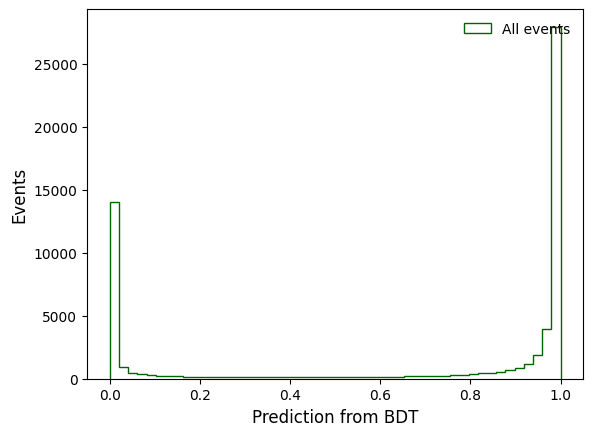

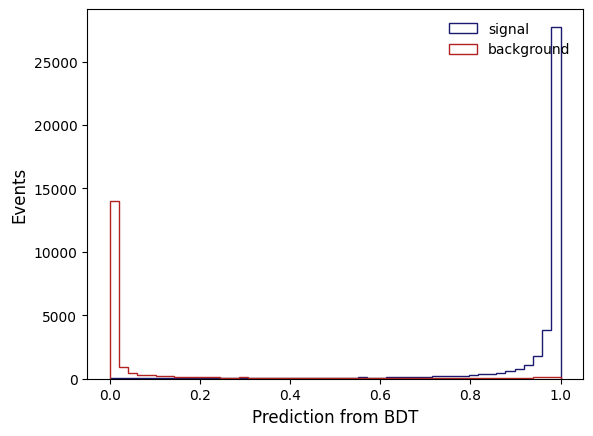

In [71]:
# plot all predictions (both signal and background)
plt.figure()
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events')
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12)
plt.ylabel('Events',fontsize=12)
plt.legend(frameon=False)

# plot signal and background separately
plt.figure()
plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal')
plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background')
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12)
plt.ylabel('Events',fontsize=12)
plt.legend(frameon=False)

/Users/nicktaylor/PycharmProjects/pythonProject/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


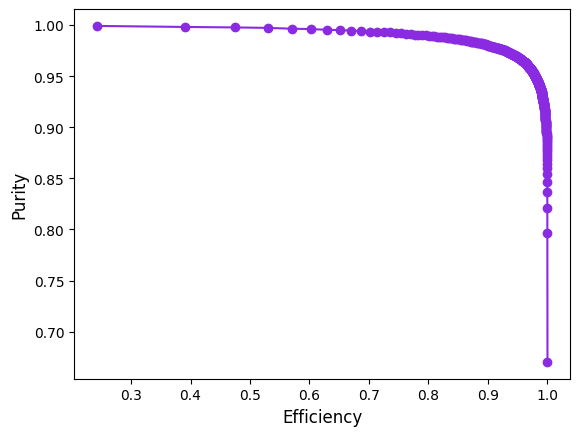

In [85]:
# choose score cuts:
cuts = np.linspace(0,1,500)
nsignal = np.zeros(len(cuts))
nbackground = np.zeros(len(cuts))
for i,cut in enumerate(cuts):
    nsignal[i] = len(np.where(predictions[test.get_label().astype(bool)] > cut)[0])
    nbackground[i] = len(np.where(predictions[~(test.get_label().astype(bool))] > cut)[0])

# plot efficiency vs. purity (ROC curve)
plt.figure()
plt.plot(nsignal/len(test_set[test_set.label == 1]),nsignal/(nsignal + nbackground),'o-',color='blueviolet')
# make the plot readable
plt.xlabel('Efficiency',fontsize=12)
plt.ylabel('Purity',fontsize=12)
plt.legend(frameon=False)

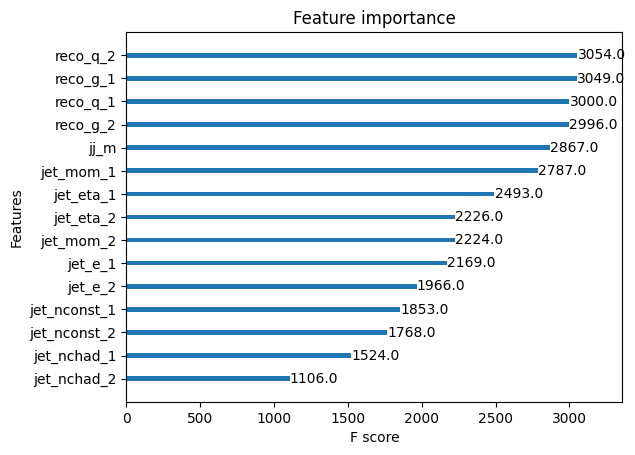

In [73]:
xgb.plot_importance(booster,grid=False);

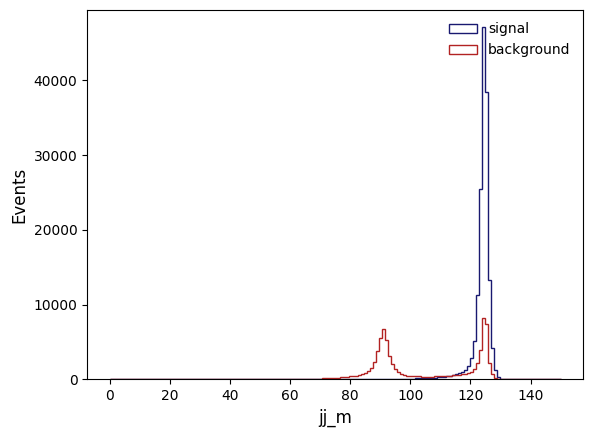

In [74]:
plt.figure()
plt.hist(training_set.jj_m[training_set.label == 1],bins=np.linspace(0,150,150),
         histtype='step',color='midnightblue',label='signal')
plt.hist(training_set.jj_m[training_set.label == 0],bins=np.linspace(0,150,150),
         histtype='step',color='firebrick',label='background')

plt.xlabel('jj_m',fontsize=12)
plt.ylabel('Events',fontsize=12)
plt.legend(frameon=False)

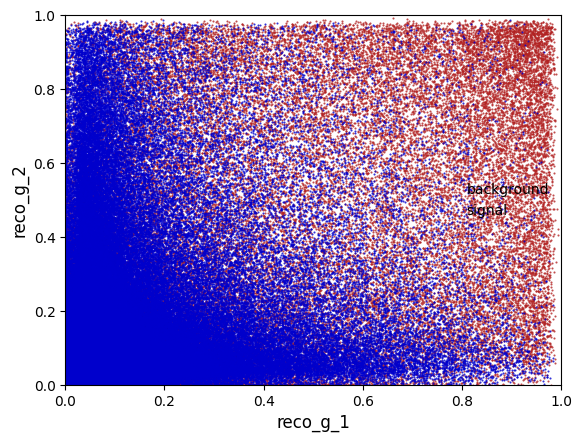

In [75]:
plt.figure()
plt.plot(training_set.reco_q_1[training_set.label == 0],training_set.reco_q_2[training_set.label == 0],
         'o',markersize=1.5,color='firebrick',markeredgewidth=0,alpha=0.8,label='background')
plt.plot(training_set.reco_q_1[training_set.label == 1],training_set.reco_q_2[training_set.label == 1],
         'o',markersize=1.5,color='mediumblue',markeredgewidth=0,alpha=0.8,label='signal')

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('reco_g_1',fontsize=12)
plt.ylabel('reco_g_2',fontsize=12)
plt.legend(frameon=False,numpoints=1,markerscale=2)

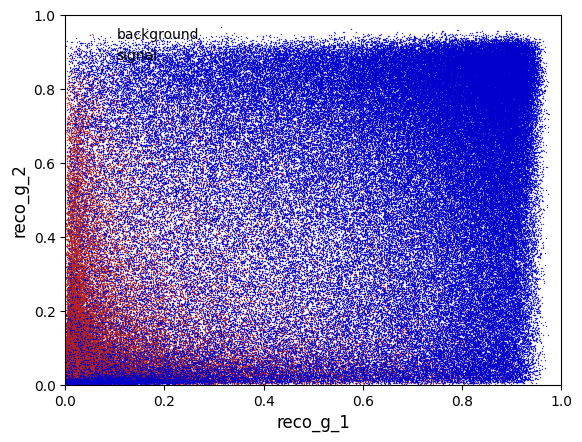

In [76]:
plt.figure()
plt.plot(training_set.reco_g_1[training_set.label == 0],training_set.reco_g_2[training_set.label == 0],
         'o',markersize=1,color='firebrick',markeredgewidth=0,alpha=0.8,label='background')
plt.plot(training_set.reco_g_1[training_set.label == 1],training_set.reco_g_2[training_set.label == 1],
         'o',markersize=1,color='mediumblue',markeredgewidth=0,alpha=0.8,label='signal')

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('reco_g_1',fontsize=12)
plt.ylabel('reco_g_2',fontsize=12)
plt.legend(frameon=False,numpoints=1,markerscale=1)

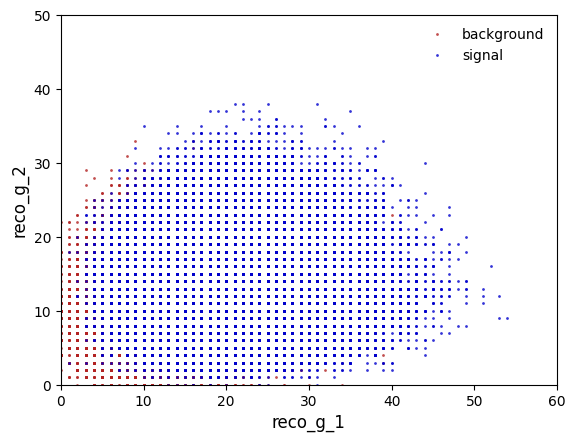

In [82]:
plt.figure()
plt.plot(training_set.jet_nchad_1[training_set.label == 0],training_set.jet_nchad_2[training_set.label == 0],
         'o',markersize=2,color='firebrick',markeredgewidth=0,alpha=0.8,label='background')
plt.plot(training_set.jet_nchad_1[training_set.label == 1],training_set.jet_nchad_2[training_set.label == 1],
         'o',markersize=2,color='mediumblue',markeredgewidth=0,alpha=0.8,label='signal')

plt.xlim(0, 60)
plt.ylim(0, 50)
plt.xlabel('reco_g_1',fontsize=12)
plt.ylabel('reco_g_2',fontsize=12)
plt.legend(frameon=False,numpoints=1,markerscale=1)